# Fig 1 Classifying pain-associated diagnoses using biological and psychosocial modalities

### This notebook contains the code for three main analyses for figure 1:

Obtain the best ROC-AUC scores from machine learning models predicting the 35 pain conitions.
Calculate the prevalence of the count of chronic pain body sites for the 35 pain conditions
Calculate the normalized prevalence of chronic pain at each body site for the 35 pain conditions.

In [18]:
# Loading in dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import zscore
from scipy import stats
import palettable

home_dir = '/Users/Patty/Desktop/EVP_lab/'

fs = 6.5
w = 0.5
sns.set_context(rc={"font.size":fs})   
plt.rcParams['font.size'] = fs
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['xtick.major.width'] = w
plt.rcParams['ytick.major.width'] = w
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.pad'] = '1.5'
plt.rcParams['ytick.minor.pad'] = '1.5'
plt.rcParams['xtick.minor.width'] = w
plt.rcParams['ytick.minor.width'] = w
plt.rcParams['axes.linewidth'] = w
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']

# Pastel2
color_mapping = {
 'Blood': '#9EB9F3',
 'Bone': '#F89C74',
 'PRS': '#DCB0F2',
 'Stacked': '#87C55F',
 'Psychosocial': '#C0BFC9'}

In [2]:
# Load data
home_dir = '/Users/Patty/Desktop/EVP_lab/'

cols = ['eid', 
        # T0
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        # T2
        'ChronicPain_T2',
        'ChronicWidespreadPain_T2', 
        'ChronicHeadaches_T2',
        'ChronicNeckShoulderPain_T2', 
        'ChronicHipPain_T2', 
        'ChronicBackPain_T2', 
        'ChronicStomachAbdominalPain_T2', 
        'ChronicKneePain_T2',
        'ChronicFacialPain_T2', 
        'NumberChronicPainTypes_T2',
       # Impact
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0',
        'OverallHealthRating_T2',
        'UnableWorkDueSicknessDisability_T2',
       # Additional
       'Age_T0',
        'Age_T1',
       'Age_T2',
       'Sex_T0']
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data
UKB = UKB.drop(columns=UKB.filter(like='T0').columns[113:172])
UKB.loc[UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T2'] == 1, 'NumberChronicPainTypes_T2'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T2'] > 4, 'NumberChronicPainTypes_T2'] = 4

# NCI Data
NCI = pd.read_csv(home_dir + 'NCI_combined.csv')
UKB = UKB.merge(NCI,on='eid')

UKB['NCI_Free_T0'] = np.where(UKB.NCI_T0 == 0,1,0)
UKB['NCI_Free_T1'] = np.where(UKB.NCI_T1 == 0,1,0)
UKB['NCI_Free_T2'] = np.where(UKB.NCI_T2 == 0,1,0)
UKB['NCI_Free_T3'] = np.where(UKB.NCI_T3 == 0,1,0)

# Load psychosocial data
t0 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T0.csv').merge(UKB[['eid','Age_T0','Sex_T0']],on='eid')
t2 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T2.csv').merge(UKB[['eid','Age_T2','Sex_T0']],on='eid')
t1 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T1.csv')

variables = pd.read_csv(home_dir + '0_Variables_V3.csv')

In [3]:
nci_cols_t0 = [
                    'NCI_fibromyalgia_T0',
                    'NCI_polymyalgia rheumatica_T0',
                    'NCI_cervical spondylosis_T0',
                    'NCI_joint pain_T0',
                    'NCI_back pain_T0',
                    'NCI_spine arthritis/spondylitis_T0',
                    'NCI_trapped nerve/compressed nerve_T0',
                    'NCI_sciatica_T0',
                    'NCI_hernia_T0',
                    'NCI_irritable bowel syndrome_T0',
                    'NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0',
                    'NCI_arthritis (nos)_T0',
                    'NCI_osteoarthritis_T0',
                    'NCI_osteoporosis_T0',
                    'NCI_rheumatoid arthritis_T0',
                    'NCI_migraine_T0',
                    'NCI_headaches (not migraine)_T0',
                    'NCI_carpal tunnel syndrome_T0',
                    'NCI_angina_T0',
                    'NCI_endometriosis_T0',
                    'NCI_gout_T0',
                    'NCI_chronic fatigue syndrome_T0',
                    'NCI_ankylosing spondylitis_T0',
                    'NCI_trigemminal neuralgia_T0',
                    'NCI_crohns disease_T0',
                    'NCI_spinal stenosis_T0',
                    'NCI_peripheral neuropathy_T0',
                    'NCI_ulcerative colitis_T0',
                    'NCI_pulmonary embolism +/- dvt_T0',
                    'NCI_chronic obstructive airways disease/copd_T0',
                    'NCI_stroke_T0',
                    'NCI_multiple sclerosis_T0',
                    'NCI_psoriatic arthropathy_T0',
                    'NCI_Post Surgical Pain_T0',
                    'NCI_disc disorder_T0',
]
nci_cols_t2 = [i.replace('T0','T2') for i in nci_cols_t0]

dico_names = {
 'joint pain': 'Joint pain',
 'spinal stenosis': 'Spinal stenosis',
 'trapped nerve/compressed nerve': 'Trapped nerve',
 'stroke': 'Stroke',
 'multiple sclerosis': 'Multiple sclerosis',
 'chronic obstructive airways disease/copd': 'COPD',
 'sciatica': 'Sciatica',
 'back pain': 'Back pain',
 'osteoporosis': 'Osteoporosis',
 'spine arthritis/spondylitis': 'Spine arthritis',
 'peripheral neuropathy': 'Peripheral neuropathy',
 'angina': 'Angina',
 'migraine': 'Migraine',
 'hernia': 'Hernia',
 'gout': 'Gout',
 'gastro-oesophageal reflux (gord) / gastric reflux': 'Gastric reflux',
 'arthritis (nos)': 'Arthritis',
 'endometriosis': 'Endometriosis',
 'cervical spondylosis': 'Cervical spondylosis',
 'irritable bowel syndrome': 'IBS',
 'headaches (not migraine)': 'Non-migraine headache',
 'chronic fatigue syndrome': 'Chronic fatigue synd.',
 'polymyalgia rheumatica': 'Polymyalgia rheumatica',
 'ulcerative colitis': 'Ulcerative colitis',
 'psoriasis': 'Psoriasis',
 'osteoarthritis': 'Osteoarthritis',
 'diverticular disease/diverticulitis': 'Diverticulitis',
 'rheumatoid arthritis': 'Rheumatoid arthritis',
 'carpal tunnel syndrome': 'Carpal tunnel synd.',
 'disc disorder': 'Disc disorder',
 'pulmonary embolism +/- dvt': 'Pulmonary embolism',
 'ankylosing spondylitis': 'Ankylosing spondylitis',
 'fibromyalgia': 'Fibromyalgia',
 'trigemminal neuralgia': 'Trigemminal neuralgia',
 'crohns disease': 'Crohns disease',
 'parkinsons disease': 'Parkinsons disease',
 'multiple sclerosis': 'Multiple sclerosis',
 'psoriatic arthropathy': 'Psoriatic arthropathy',
 'Post Surgical Pain': 'Post surgical pain',
 'peripheral vascular disease': 'Peripheral vasc. disease',
 'Free': 'Diagnosis-free'
         }

In [9]:
# Extracting from machine learning models which are stored in pickled dictionaries
diag_T0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T0_diagnoses_clf-LR_lin.pickle')
diag_T0 = {key: value for key, value in diag_T0.items() if 'parkinson' not in key}
diag_T0 = {key: value for key, value in diag_T0.items() if 'peripheral vascular disease' not in key}

diag_T2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T2_diagnoses_clf-LR_lin.pickle')
diag_T2 = {key: value for key, value in diag_T2.items() if 'parkinson' not in key}
diag_T2 = {key: value for key, value in diag_T2.items() if 'peripheral vascular disease' not in key}
diag_T2 = {key: value for key, value in diag_T2.items() if 'Psycho' not in key}

In [10]:
def pivot_pickle(df,cols):
    
    T0_cat = pd.concat([df[i]['results_df'] for i in df.keys()])
    T0_cat.index = [i[:-4] for i in T0_cat.index]
    T0_auc = T0_cat.groupby(level=0).mean().AUC_test
    ind = np.unique([i.split('_')[1:-1][0] for i in T0_auc.index])
    df = pd.concat([T0_auc[T0_auc.index.str.contains(i)].reset_index(drop=True) for i in cols],axis=1)
    df.index = ind
    df.columns = cols
    
    return df

T0_auc = pivot_pickle(diag_T0,cols=['Blood','Inflammatory','Metabolic','CBC','PRS','Psycho'])
T2_auc = pivot_pickle(diag_T2,cols=['Stacked','T1','fMRI','DWI','Bone'])

merged_auc = pd.concat([T0_auc,T2_auc],axis=1)

# Calculate the Z-score for each column
tmp = merged_auc.drop(columns=['Stacked','Psycho'])
zscore_df = tmp.apply(zscore)

# Filter the rows with a Z-score greater than 0 for each column
filtered_rows = zscore_df[zscore_df > 1].dropna(how='all')

# Concatenate all unique illness names
unique_illnesses = filtered_rows.index.unique()

#  Top 5
unique_illnesses = list(set(np.concatenate([tmp[i].sort_values(ascending=False)[:5].index.tolist() for i in tmp.columns])))

# All 40
all_illnesses = merged_auc.index.tolist()

In [13]:
def extract_dataframes_from_dict(data_dict):
    """Extract dataframes from the dictionary and return a concatenated dataframe."""
    concatenated_df = pd.concat([data_dict[key]['results_df'] for key in data_dict.keys()])
    concatenated_df.index = [i[:-4] for i in concatenated_df.index]
    return concatenated_df

def filter_dataframe(df, filter_strings, mode="exclude"):
    """Filter the dataframe based on a list of strings either for exclusion or inclusion."""
    if mode == "exclude":
        for f_str in filter_strings:
            df = df[~df.index.str.contains(f_str)]
    elif mode == "include":
        df = df[df.index.str.contains(filter_strings[0])]
    return df

def process_df(df):
    """Process the dataframe to add Modality, illness columns and find max AUC_test."""
    grouped_df = df.groupby(level=0).mean()
    grouped_df['Modality'] = [i.split('_')[-1] for i in grouped_df.index]
    grouped_df['illness'] = [i.split('_')[1] for i in grouped_df.index]

    idx = grouped_df.groupby('illness')['AUC_test'].idxmax()
    df_best = df.loc[idx].reset_index()
    df_best['Modality'] = [i.split('_')[-1] for i in df_best['index']]
    
    return df_best

# Pre-processing and extracting the data
t0_auc = extract_dataframes_from_dict(diag_T0)[['AUC_test']]
t0_auc = t0_auc[~t0_auc.index.str.contains('ankylosing spondylitis_Blood')] # Removing AS blood to put PRS ahead
t2_auc = extract_dataframes_from_dict(diag_T2)
t2_auc = filter_dataframe(t2_auc, ['Psychosocial'])[['AUC_test']]
combined_df = pd.concat([t0_auc, t2_auc])

# Splitting the data into 'bio' and 'psych' based on the criteria
exclusion_filters = ['Psychosocial', 'Inflamm', 'Metab', 'CBC', 'DWI', 'fMRI', 'T1']
bio = filter_dataframe(combined_df, exclusion_filters)
exclusion_filters = ['Psychosocial', 'Stacked', 'Blood']
bio_hm = filter_dataframe(combined_df, exclusion_filters)
psych = filter_dataframe(combined_df, ['Psychosocial'], mode="include")

# Processing the dataframes to obtain the desired format
bio = process_df(bio)
bio_hm = process_df(bio_hm)
psych = process_df(psych)


In [14]:
from sklearn.impute import SimpleImputer
from confounds import Residualize
from scipy.stats import zscore

inf = [
    'CReactiveProtein_T0', 
    'EosinophillCount_T0', 
    'BasophileCount_T0', 
    'MonocyteCount_T0', 
    'NeutrophillCount_T0', 
    'WhiteBloodCellLeukocyteCount_T0', 
    'BasophilePercentage_T0',
    'EosinophillPercentage_T0',
    'MonocytePercentage_T0',
    'NeutrophillPercentage_T0',
    'LymphocyteCount_T0',
    'LymphocytePercentage_T0'
]
met = [
    'Glucose_T0', 
    'AlanineAminotransferase_T0', 
    'AspartateAminotransferase_T0', 
    'AlkalinePhsophate_T0', 
    'TotalBilirubin_T0', 
    'Urea_T0', 
    'Creatinine_T0', 
    'Albumin_T0', 
    'Calcium_T0', 
    'TotalProtein_T0', 
    'Sodium_T0', 
    'Potassium_T0',
    'Phosphate_T0',
    'CreatinineEnzymatic_T0',
    'AlipoproteinA_T0', 
    'AlipoproteinB_T0', 
    'GammaGlutamyltransferase_T0', 
    'Triglyceride_T0', 
    'VitaminD_T0', 
    'Testosterone_T0', 
    'IGF1_T0', 
    'LDLDirect_T0', 
    'Urate_T0', 
    'HDLCholesterol_T0', 
    'Cholesterol_T0',
    'CystatinC_T0', 
    'GlycatedHaemoglobin_T0'
]
cbc = [
    'HaematocritPercentage_T0', 
    'HaemoglobinConcentration_T0', 
    'PlateletDistributionWidth_T0', 
    'MeanPlateletThrombocyteVolume_T0', 
    'PlateletCrit_T0', 
    'PlateletCount_T0',
    'RedBloodCellErythrocyteCount_T0', 
    'RedBloodCellErythrocyteDistributionWidth_T0', 
    'HighLightScatterReticulocyteCount_T0', 
    'HighLightScatterReticulocytePercentage_T0', 
    'ReticulocyteCount_T0', 
    'ReticulocytePercentage_T0', 
    'ImmatureReticulocyteFraction_T0', 
    'MeanReticulocyteVolume_T0', 
    'MeanSpheredCellVolume_T0', 
    'NucleatedRedBloodCellCount_T0', 
    'NucleatedRedBloodCellPercentage_T0'
]

blood_categories = [inf,met,cbc]

def transform_blood_data(blood, log=True):
    """
    Impute missing values with the median and apply log transformation to all columns except the first one,
    using log1p if zeros are present in the feature.
    
    Parameters:
    - blood (pd.DataFrame): Input DataFrame with blood data.
    
    Returns:
    - pd.DataFrame: Transformed blood data.
    """
    
    # Impute missing values with median
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    blood_data = pd.DataFrame(imp_med.fit_transform(blood), columns=blood.columns)
    
    # Apply log transformation as required
    if log:
        for column in blood_data.columns[1:]:  # Exclude the first column (subject ID)
            if (blood_data[column] == 0).any():  # Check if there are zero values in the column
                blood_data[column] = np.log1p(blood_data[column])
            else:
                # Avoid taking log of zero or negative values by adding 1
                blood_data[column] = np.log(blood_data[column])
    
    return blood_data

blood = pd.read_csv(home_dir + 'UKB_New_Blood_Immuno_T0.csv')
threshold = len(blood.columns) / 2 
blood = blood.dropna(thresh=threshold) # Drop subjects missing >= 50% of features
blood_data = transform_blood_data(blood)

# Identify the assays based on the column names
assays = [i for i in blood_data.filter(like='T0').columns]

blood_merged = blood_data.merge(UKB[['eid','Age_T0','Sex_T0']],on='eid')
resid_t0 = Residualize()
X_t0 = zscore(blood_merged[assays])

blood_data = pd.DataFrame(X_t0)
blood_data.index = blood_merged.eid


In [15]:
from sklearn.metrics import roc_auc_score
names = ['Inflammatory','Metabolic','CBC']
auc_scores_df = pd.DataFrame(index=merged_auc.index, columns=names)

for dx in merged_auc.index:
    for idx,cat in  enumerate(blood_categories):
        w = pd.concat([diag_T0[i]['weights'][0] for i in diag_T0 if f'{dx}_Blood' in i]).groupby(level=0, sort=False).mean()
        subs = pd.concat([pd.DataFrame(diag_T0[i]['roc_curve'][:2],index=['eid','y']) for i in diag_T0.keys() if f'{dx}_Blood_Iter-0' in i],axis=1).T.sort_values('eid')
        sub_w = w.reindex(cat)
        vals = blood_data[blood_data.index.isin(subs.eid)][cat]
        sig = np.dot(sub_w.T,vals.T)
        auc_score = roc_auc_score(subs['y'], sig.T)
        auc_scores_df.loc[dx, names[idx]] = auc_score
        
merged_auc[['Inflammatory','Metabolic','CBC']] = auc_scores_df.astype(float)

# Biological

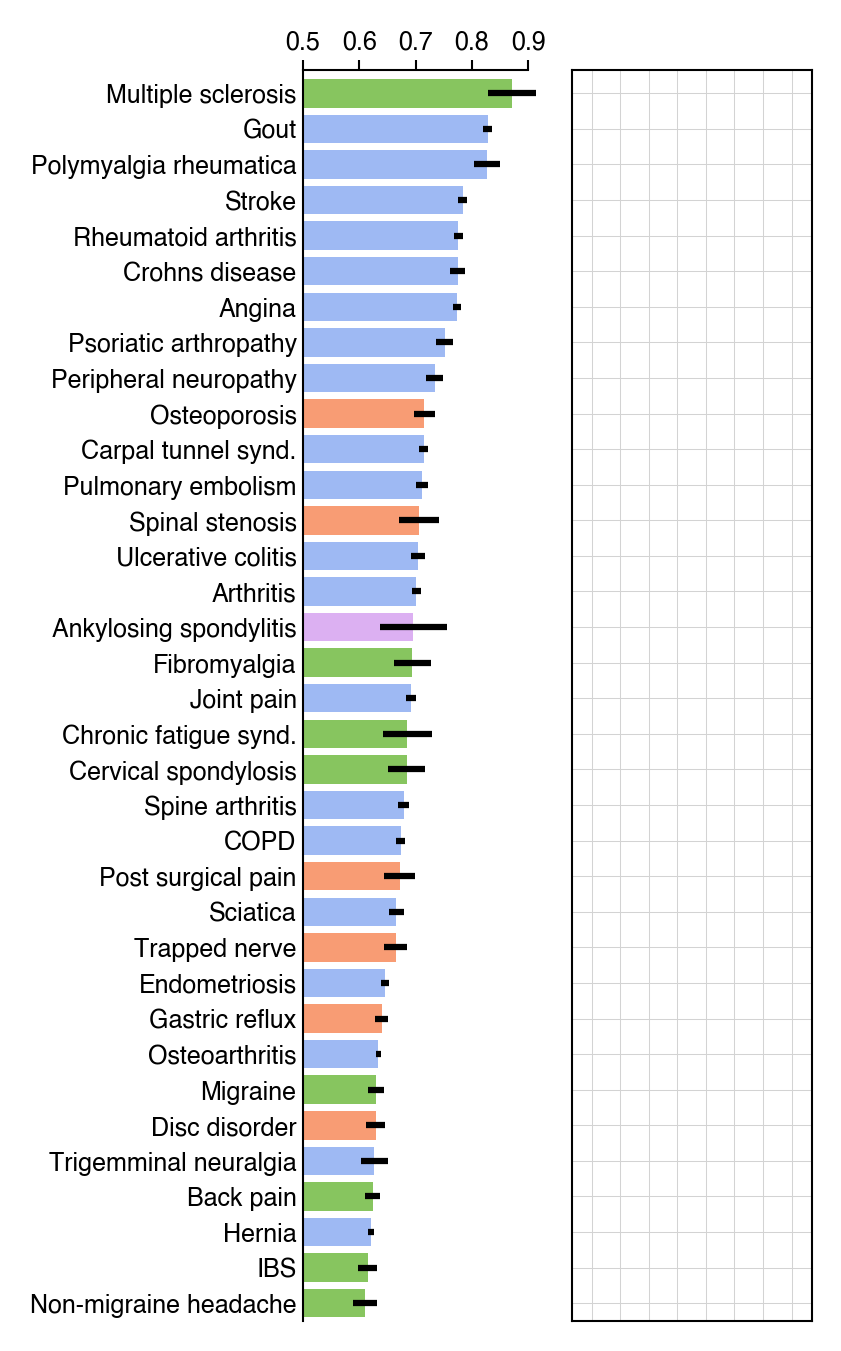

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import palettable
from palettable.cartocolors.sequential import Teal_7

# Predefined dico_names, color_mapping, and ncis

# Copy the 'bio' DataFrame and process columns
merged_df = bio.copy()
merged_df['index'] = [i.split('_')[1] for i in merged_df['index']]
merged_df['Modality_bin'] = np.where(merged_df['Modality'] == 'Psychosocial', 'Psychosocial', 'Bio')
merged_df = merged_df[merged_df['index'].isin(ncis)]

# AUC calculations and merging
avg_auc_bio = merged_df[merged_df['Modality_bin'] == 'Bio'].groupby('index')['AUC_test'].mean().reset_index()
avg_auc_bio.columns = ['index', 'Avg_AUC_Bio']
merged_df = merged_df.merge(avg_auc_bio, on='index', how='left')
merged_df = merged_df.sort_values('Avg_AUC_Bio', ascending=False)

# Update 'index' to use the corresponding names
merged_df['index'] = [dico_names[i] for i in merged_df['index']]
y_values = {illness: i for i, illness in enumerate(merged_df['index'].unique())}
order = merged_df['index'].unique().tolist()
bio_order = order.copy()

# Plot initialization
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(2.8, 4.5), gridspec_kw={'width_ratios': [1, 1]})

################################################################################ PLOT 2: Barplot AUC ################################################################################
merged_df = merged_df[merged_df['Modality'] != 'Psychosocial']
data_modality = merged_df[merged_df['Modality_bin'] == 'Bio'].groupby('index')
unique_modalities_df = merged_df.drop_duplicates(subset=['index', 'Modality'])
bar_colors = [color_mapping[category] for category in unique_modalities_df['Modality']]
std_devs = merged_df.groupby('index')['AUC_test'].std().reindex(order)

adjusted_order_positions = [y_values[i] for i in order]
ax1.barh(adjusted_order_positions, merged_df.groupby('index', sort=False)['AUC_test'].mean(), color=bar_colors, xerr=std_devs, align='center')
sns.despine(bottom=True, top=False, left=False, right=True, ax=ax1)
ax1.set(xlabel='', xlim=(.5, .925), xticks=[.5, .6, .7, .8, .9])
ax1.set_xticklabels([.5, .6, .7, .8, .9], fontsize=6)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.spines["top"].set_bounds((.5, .9))
ax1.set_yticks(np.arange(len(order) + 0.5), minor=True)
ax1.set_ylim(len(order)-.5, -.65)
ax1.tick_params(axis='y', which='major', length=0, labelsize=6)

################################################################################ PLOT 2: Bubble Heatmap ################################################################################
reduced = merged_auc.sort_index()
cols = ['Inflammatory', 'Metabolic', 'CBC', 'DWI', 'fMRI', 'T1', 'Bone', 'PRS']
reduced = reduced[cols]
reduced.index = [dico_names[i] for i in reduced.index]
data_for_heatmap = zscore(reduced[cols]).loc[merged_df.groupby('index', sort=False)['AUC_test'].mean().index]

long_zscore = data_for_heatmap.stack().reset_index()
long_zscore.columns = ['Disease', 'Metric', 'Zscore']

data_for_raw_auc = merged_auc[data_for_heatmap.columns]
long_auc = data_for_raw_auc.stack().reset_index().iloc[:-4]
long_auc.columns = ['Disease', 'Metric', 'AUC']
long_auc['Disease'] = [dico_names[i] for i in long_auc.Disease.values]

merged_data = pd.merge(long_zscore, long_auc, on=['Disease', 'Metric'])
merged_data['x_val'] = merged_data['Metric'].map({
    'Inflammatory': 0, 
    'Metabolic': 1,   
    'CBC': 2,       
    'DWI': 3,   
    'fMRI': 4,
    'T1': 5,
    'Bone': 6,
    'PRS': 7
})

min_zscore, max_zscore = 0.55, .9
min_auc, max_auc = 0, 2.75
zscore_range = (min_zscore, max_zscore)
auc_range = (min_auc, max_auc)
cmap = palettable.cartocolors.sequential.Teal_7.mpl_colormap

sns.scatterplot(x='x_val', y='Disease', size='Zscore', hue='AUC', 
                sizes=(0, 0), data=merged_data, palette='Blues',
                hue_norm=zscore_range, size_norm=auc_range, edgecolor='k', linewidth=.15,
                zorder=5,ax=ax2)
ax2.legend('',frameon=False)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.set_xmargin(0.1)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', length=0, labelleft=False, labelbottom=False, left=False, bottom=False)
ax2.grid(True, which='major', linestyle='-', axis='both', linewidth=0.25, color='lightgrey', zorder=0)

for _, spine in ax2.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5)

plt.tight_layout()
plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/Dx_biobar.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

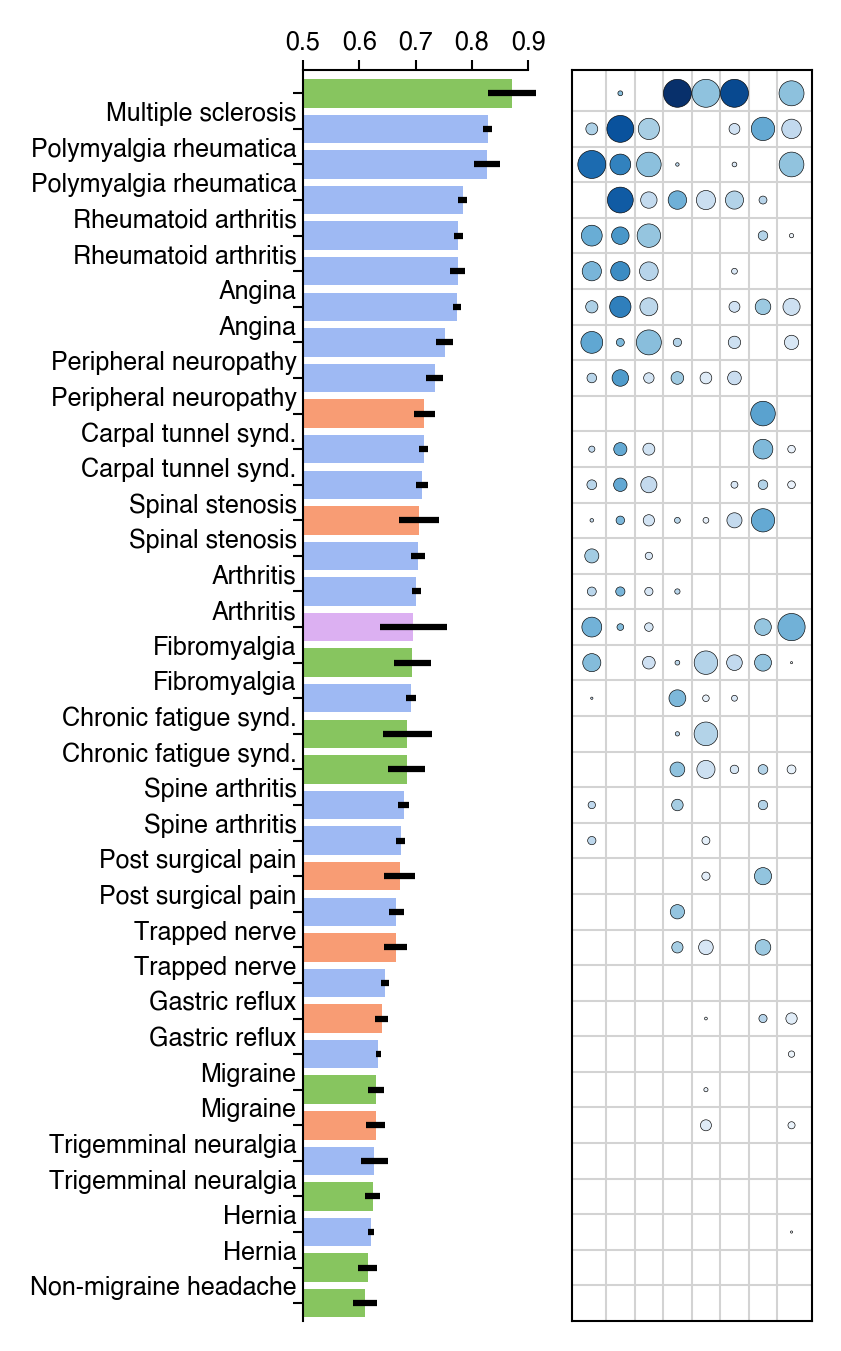

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from palettable.cartocolors.sequential import Teal_7

# Assuming predefined dico_names, color_mapping, and ncis

# Copy the 'bio' DataFrame and process columns
merged_df = bio.copy()
merged_df['index'] = [i.split('_')[1] for i in merged_df['index']]
merged_df['Modality_bin'] = np.where(merged_df['Modality'] == 'Psychosocial', 'Psychosocial', 'Bio')
merged_df = merged_df[merged_df['index'].isin(ncis)]

# AUC calculations and merging
avg_auc_bio = merged_df[merged_df['Modality_bin'] == 'Bio'].groupby('index')['AUC_test'].mean().reset_index()
avg_auc_bio.columns = ['index', 'Avg_AUC_Bio']
merged_df = merged_df.merge(avg_auc_bio, on='index', how='left')
merged_df = merged_df.sort_values('Avg_AUC_Bio', ascending=False)

# Update 'index' to use the corresponding names
merged_df['index'] = [dico_names[i] for i in merged_df['index']]
y_values = {illness: i for i, illness in enumerate(merged_df['index'].unique())}
order = merged_df['index'].unique().tolist()
bio_order = order.copy()

# Plot initialization
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(2.8, 4.5), gridspec_kw={'width_ratios': [1, 1]})

################################################################################ PLOT 2: Barplot AUC ################################################################################
merged_df = merged_df[merged_df['Modality'] != 'Psychosocial']
data_modality = merged_df[merged_df['Modality_bin'] == 'Bio'].groupby('index')
unique_modalities_df = merged_df.drop_duplicates(subset=['index', 'Modality'])
bar_colors = [color_mapping[category] for category in unique_modalities_df['Modality']]
std_devs = merged_df.groupby('index')['AUC_test'].std().reindex(order)

adjusted_order_positions = [y_values[i] for i in order]
ax1.barh(adjusted_order_positions, merged_df.groupby('index', sort=False)['AUC_test'].mean(), color=bar_colors, xerr=std_devs, align='center')
sns.despine(bottom=True, top=False, left=False, right=True, ax=ax1)
ax1.set(xlabel='', xlim=(.5, .925), xticks=[.5, .6, .7, .8, .9])
ax1.set_xticklabels([.5, .6, .7, .8, .9], fontsize=6)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.spines["top"].set_bounds((.5, .9))
ax1.set_yticks(np.arange(len(order) + 0.5), minor=True)
ax1.set_ylim(len(order)-.5, -.65)
ax1.tick_params(axis='y', which='major', length=0, labelsize=6)

################################################################################ PLOT 2: Bubble Heatmap ################################################################################
reduced = merged_auc.sort_index()
cols = ['Inflammatory', 'Metabolic', 'CBC', 'DWI', 'fMRI', 'T1', 'Bone', 'PRS']
reduced = reduced[cols]
reduced.index = [dico_names[i] for i in reduced.index]
data_for_heatmap = zscore(reduced[cols]).loc[merged_df.groupby('index', sort=False)['AUC_test'].mean().index]

long_zscore = data_for_heatmap.stack().reset_index()
long_zscore.columns = ['Disease', 'Metric', 'Zscore']

data_for_raw_auc = merged_auc[data_for_heatmap.columns]
long_auc = data_for_raw_auc.stack().reset_index().iloc[:-4]
long_auc.columns = ['Disease', 'Metric', 'AUC']
long_auc['Disease'] = [dico_names[i] for i in long_auc.Disease.values]

merged_data = pd.merge(long_zscore, long_auc, on=['Disease', 'Metric'])
merged_data['x_val'] = merged_data['Metric'].map({
    'Inflammatory': 0, 
    'Metabolic': 1,   
    'CBC': 2,       
    'DWI': 3,   
    'fMRI': 4,
    'T1': 5,
    'Bone': 6,
    'PRS': 7
})

min_zscore, max_zscore = 0.55, .85
min_auc, max_auc = 0, 2.75
zscore_range = (min_zscore, max_zscore)
auc_range = (min_auc, max_auc)
cmap = palettable.cartocolors.sequential.Teal_7.mpl_colormap

sns.scatterplot(x='x_val', y='Disease', size='Zscore', hue='AUC', 
                sizes=(0, 45), data=merged_data, palette='Blues',
                hue_norm=zscore_range, size_norm=auc_range, edgecolor='k', linewidth=.15,
                zorder=5,ax=ax2)
ax2.legend('',frameon=False)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.set_xmargin(0.1)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', length=0, labelleft=False, labelbottom=False, left=False, bottom=False)

# Set the ticks based on your data. Assuming each unique 'x_val' and 'Disease' represents a grid square:
unique_x_vals = sorted(merged_data['x_val'].unique())
unique_diseases = sorted(merged_data['Disease'].unique())
ax2.set_xticks([val + 0.5 for val in unique_x_vals[:-1]])  # position the x-ticks between the data points
ax2.set_yticks([val + 0.5 for val in range(len(unique_diseases) - 1)])  # position the y-ticks between the data points
ax2.tick_params(axis='both', which='both', length=0, bottom=False)
ax2.set_xticklabels([])
# Major grid
ax2.grid(True, which='major', linestyle='-', axis='both', linewidth=0.5, color='lightgrey', zorder=0)

for _, spine in ax2.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5)

plt.tight_layout()
plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/Dx_biobar_bubble.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

# Psychosocial

In [23]:
# Reload data if necessary
home_dir = '/Users/Patty/Desktop/EVP_lab/'

cols = ['eid', 
        # T0
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        # T2
        'ChronicPain_T2',
        'ChronicWidespreadPain_T2', 
        'ChronicHeadaches_T2',
        'ChronicNeckShoulderPain_T2', 
        'ChronicHipPain_T2', 
        'ChronicBackPain_T2', 
        'ChronicStomachAbdominalPain_T2', 
        'ChronicKneePain_T2',
        'ChronicFacialPain_T2', 
        'NumberChronicPainTypes_T2',
       # Impact
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0',
        'OverallHealthRating_T2',
        'UnableWorkDueSicknessDisability_T2',
       # Additional
       'Age_T0',
        'Age_T1',
       'Age_T2',
       'Sex_T0']
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data
UKB = UKB.drop(columns=UKB.filter(like='T0').columns[113:172])
UKB.loc[UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T2'] == 1, 'NumberChronicPainTypes_T2'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T2'] > 4, 'NumberChronicPainTypes_T2'] = 4

# NCI Data
NCI = pd.read_csv(home_dir + 'NCI_combined.csv')
UKB = UKB.merge(NCI,on='eid')

# NCI_age = pd.read_csv('/Users/Patty/Desktop/EVP_lab/UKB_Age_NonCancer_Illness.csv')
# UKB = UKB.merge(NCI_age,on='eid')

UKB['NCI_Free_T0'] = np.where(UKB.NCI_T0 == 0,1,0)
UKB['NCI_Free_T1'] = np.where(UKB.NCI_T1 == 0,1,0)
UKB['NCI_Free_T2'] = np.where(UKB.NCI_T2 == 0,1,0)
UKB['NCI_Free_T3'] = np.where(UKB.NCI_T3 == 0,1,0)

# Load psychosocial data
t0 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T0.csv').merge(UKB[['eid','Age_T0','Sex_T0']],on='eid')
t2 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T2.csv').merge(UKB[['eid','Age_T2','Sex_T0']],on='eid')
t1 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T1.csv')

variables = pd.read_csv(home_dir + '0_Variables_V3.csv')

# Compute AUC scores for Psychosocial submodalities

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

T = 'T0'
bs = 1
psych_values = t0

# Regress Age and Sex from psychosocial
import statsmodels.api as sm
# List of columns you want to regress out effects from
cols_to_regress = [col for col in psych_values.columns if col not in ['eid', f'Age_{T}', 'Sex_T0']]

for col in cols_to_regress:
    # Define independent variables (with an intercept)
    X = psych_values[[f'Age_{T}', 'Sex_T0']]
    X = sm.add_constant(X)
    
    # Define dependent variable
    y = psych_values[col]
    
    # Fit linear regression model
    model = sm.OLS(y, X).fit()
    
    # Get the residuals
    residuals = model.resid
    
    # Replace original data with residuals
    psych_values[col] = residuals
        
    
def get_weights_for_dim(diag, nci, dim_name, variables):
    if dim_name:
        relevant_vars = variables[variables['Category'] == dim_name].Name.values + '_' + T
    else:
        relevant_vars = variables.Name.values + '_' + T
        
    return pd.concat([diag[i]['weights'][0].reindex(relevant_vars).dropna() for i in diag.keys() if f'{nci}_Psychosocial' in i]).groupby(level=0).mean()

def compute_signature(weights, psych_data):
    signature = np.dot(weights.T, psych_data[weights.index].T)
    return signature.flatten()  # Ensure the output is 1D

def roc_for_dim(df, nci_col, dim):
    return roc_auc_score(df[nci_col], df[dim])

def bootstrap_roc(df_ill, nci_col, dim_name, n_bootstrap=bs):
    bootstrapped_scores = []
    
    for _ in range(n_bootstrap):
        # Randomly sample data with replacement
        df_sampled = resample(df_ill, replace=True)
        
        # Compute ROC score on the sampled data
        score = roc_for_dim(df_sampled, nci_col, dim_name)
                
        bootstrapped_scores.append(score)
    
    mean_score = np.mean(bootstrapped_scores)
    lower_ci = np.percentile(bootstrapped_scores, 2.5)
    upper_ci = np.percentile(bootstrapped_scores, 97.5)
    
    return mean_score

results = []

for nci in merged_auc.index:
    dims = ["", 'Occupational', 'Mood', 'Socioeconomic', 'Neuroticism', 'SubstanceUse', 'PhysicalActivity', 'Traumas', 'Sleep']
    dim_names = ["Full", 'Occupational', 'Mood', 'Socioeconomic', 'Neuroticism', 'SubstanceUse', 'PhysicalActivity', 'Traumas', 'Sleep']
    
    signatures = {}
    
    for dim, dim_name in zip(dims, dim_names):
        weights = get_weights_for_dim(diag_T0, nci, dim, variables)
        
        # Check if weights DataFrame is not empty
        if not weights.empty:
            signatures[dim_name] = compute_signature(weights, psych_values)
        else:
            signatures[dim_name] = np.array([np.nan] * len(psych_values.eid.values))
            
    df_dict = {'eid': psych_values.eid.values}
    df_dict.update(signatures)
    
    df = pd.DataFrame(df_dict)
    
    df = df.merge(UKB[['eid', f'NCI_{nci}_{T}', f'NCI_{T}']], on='eid')
    df_ill = df[(df[f'NCI_{nci}_{T}'] == 1) | (df[f'NCI_{T}'] == 0)]
    
    rocs = {dim_name: bootstrap_roc(df_ill, f'NCI_{nci}_{T}', dim_name) for dim_name in dim_names}
    
    result = {'NCI': nci}
    result.update(rocs)
    results.append(result)

result_df = pd.DataFrame(results).set_index('NCI')
result_df = result_df[result_df.index.isin(ncis)]
result_df.index = [dico_names[i] for i in result_df.index]

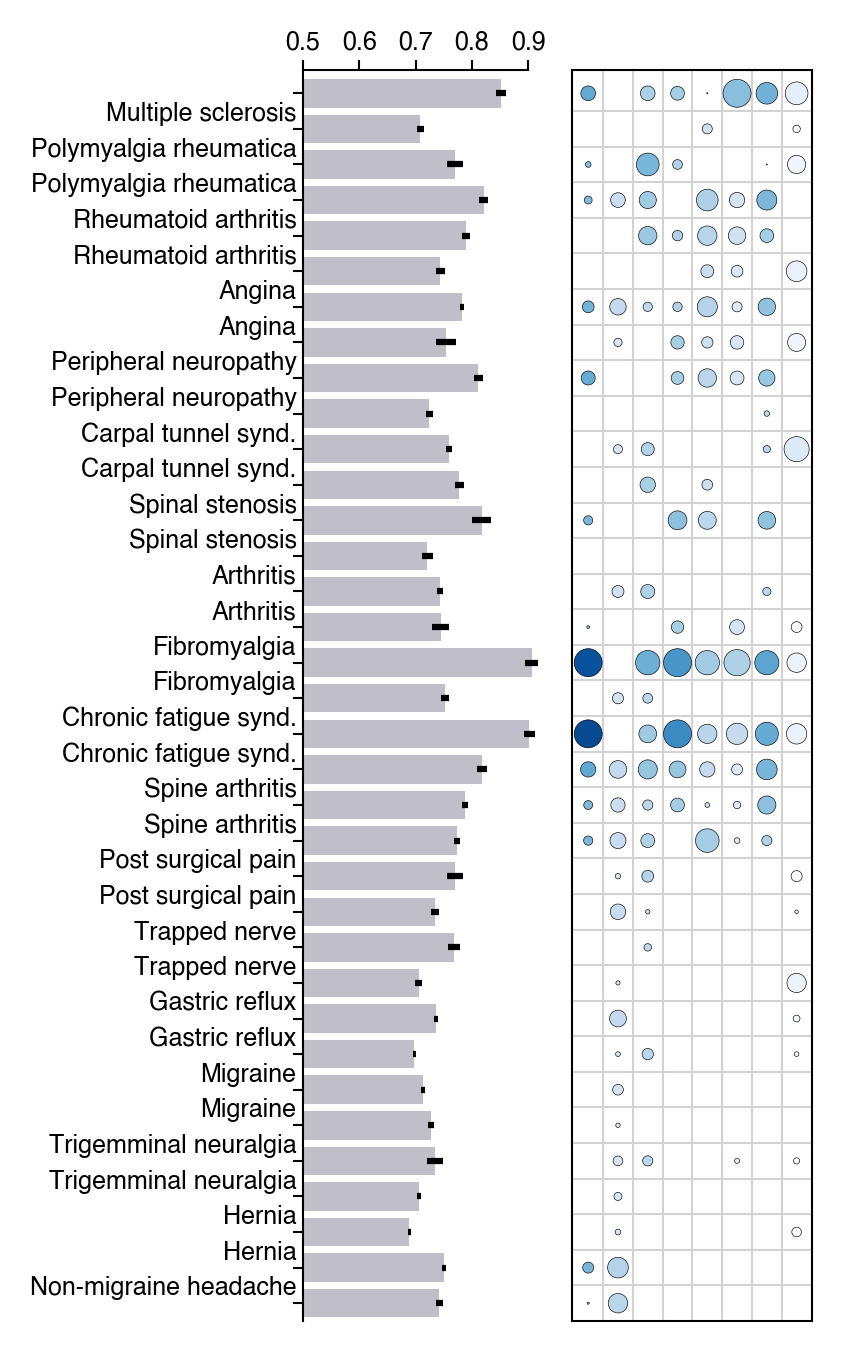

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from palettable.cartocolors.sequential import Teal_7

# Copy the 'psych' DataFrame to 'merged_df' and extract 'Modality_bin'
merged_df = psych.copy()
merged_df['index'] = [i.split('_')[1] for i in merged_df['index']]
merged_df['Modality_bin'] = np.where(merged_df['Modality'] == 'Psychosocial', 'Psychosocial', 'Bio')

# Filter based on 'ncis' and calculate average AUC scores for 'Psychosocial' modality
merged_df = merged_df[merged_df['index'].isin(ncis)]
avg_auc_psych = merged_df[merged_df['Modality_bin'] == 'Psychosocial'].groupby('index')['AUC_test'].mean().reset_index()
avg_auc_psych.columns = ['index', 'Avg_AUC']

# Merge with 'merged_df' and sort
# merged_df = merged_df.merge(avg_auc_psych, on='index', how='left').sort_values('Avg_AUC', ascending=False)
merged_df = merged_df.merge(avg_auc_psych, on='index', how='left')

merged_df['index'] = [dico_names[i] for i in merged_df['index']]

# Set y-values and order for plotting
y_values = {illness: i for i, illness in enumerate(merged_df['index'].unique())}
# order = merged_df['index'].unique().tolist()

# Initiate plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(2.8, 4.5), gridspec_kw={'width_ratios': [1, 1]})

# Prepare data for first plot
cols = ['Mood', 'Neuroticism', 'Traumas',
        'Sleep', 'SubstanceUse', 'PhysicalActivity',
        'Socioeconomic', 'Occupational']
result_df = result_df.loc[merged_df['index'].unique()]
data_for_heatmap = zscore(result_df[cols])
data_for_heatmap = data_for_heatmap.loc[merged_df.groupby('index', sort=False)['AUC_test'].mean().index]
long_zscore = data_for_heatmap.stack().reset_index()
long_zscore.columns = ['Disease', 'Metric', 'Zscore']
data_for_raw_auc = result_df[data_for_heatmap.columns]
long_auc = data_for_raw_auc.stack().reset_index().iloc[:-4].rename(columns={'level_0': 'Disease', 'level_1': 'Metric', 0: 'AUC'})
merged_data = pd.merge(long_zscore, long_auc, on=['Disease', 'Metric'])
merged_data['x_val'] = merged_data['Metric'].map({'Mood': 0, 'Neuroticism': 1, 'Traumas': 2, 'Sleep': 3, 'SubstanceUse': 4, 'PhysicalActivity': 5, 'Socioeconomic': 6, 'Occupational': 7})

# Plot initialization
################################################################################ PLOT 2: Barplot AUC ################################################################################
data_modality = merged_df[merged_df['Modality_bin'] == 'Psychosocial'].groupby('index')
unique_modalities_df = merged_df.drop_duplicates(subset=['index', 'Modality'])
bar_colors = [color_mapping[category] for category in unique_modalities_df['Modality']]
std_devs = merged_df.groupby('index')['AUC_test'].std().reindex(bio_order)
adjusted_order_positions = [y_values[i] for i in bio_order]
bar_data = merged_df.groupby('index', sort=False)['AUC_test'].mean()
ax1.barh(bio_order, bar_data.loc[bio_order], color=bar_colors, xerr=std_devs, align='center')

sns.despine(bottom=True, top=False, left=False, right=True, ax=ax1)
ax1.set(xlabel='', xlim=(.5, .925), xticks=[.5, .6, .7, .8, .9])
ax1.set_xticklabels([.5, .6, .7, .8, .9], fontsize=6)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.spines["top"].set_bounds((.5, .9))
ax1.set_yticks(np.arange(len(order) + 0.5), minor=True)
ax1.set_ylim(len(order)-.5, -.65)
ax1.tick_params(axis='y', which='major', length=0, labelsize=6)

################################################################################ PLOT 2: Bubble Heatmap ################################################################################
min_zscore, max_zscore = 0.55, .9 # .85
min_auc, max_auc = 0, 2.75
zscore_range = (min_zscore, max_zscore)
auc_range = (min_auc, max_auc)

cmap = palettable.cartocolors.sequential.agGrnYl_7_r.mpl_colormap

sns.scatterplot(x='x_val', y='Disease', size='Zscore', hue='AUC', sizes=(0, 45), data=merged_data, palette='Blues', 
                hue_norm=(0.55, .9), size_norm=(0, 2.75), edgecolor='k', linewidth=.15, zorder=5, ax=ax2)
ax2.legend('',frameon=False)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.set_xlim(-0.55,7.5)
ax2.set_xmargin(0.1)
ax2.set_xlabel('')
# Set the ticks based on your data. Assuming each unique 'x_val' and 'Disease' represents a grid square:
unique_x_vals = sorted(merged_data['x_val'].unique())
unique_diseases = sorted(merged_data['Disease'].unique())
ax2.set_xticks([val + 0.5 for val in unique_x_vals[:-1]])  # position the x-ticks between the data points
ax2.set_yticks([val + 0.5 for val in range(len(unique_diseases) - 1)])  # position the y-ticks between the data points
ax2.tick_params(axis='both', which='both', length=0, bottom=False)
ax2.set_xticklabels([])

# Major grid
ax2.grid(True, which='major', linestyle='-', axis='both', linewidth=0.5, color='lightgrey', zorder=0)

for _, spine in ax2.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(.5)

plt.tight_layout()
plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/Dx_Psycho_bar.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

# Scatter plot comparing biological to psychosocial ROC-AUC scores

In [27]:
dico_names_nfl = {'joint pain': 'Joint pain',
 'spinal stenosis': 'Spinal sten.',
 'trapped nerve/compressed nerve': 'Trapped nerve',
 'stroke': 'Stroke',
 'multiple sclerosis': 'Multiple sclerosis',
 'chronic obstructive airways disease/copd': 'COPD',
 'sciatica': 'Sciatica',
 'back pain': 'Back pain',
 'osteoporosis': 'Osteoporosis',
 'spine arthritis/spondylitis': 'Spine arth.',
 'peripheral neuropathy': 'Periph. neurop.',
 'angina': 'Angina',
 'migraine': 'Migr.',
 'hernia': 'Hernia',
 'gout': 'Gout',
 'gastro-oesophageal reflux (gord) / gastric reflux': 'Gastric ref.',
 'arthritis (nos)': 'Arthritis',
 'endometriosis': 'Endometriosis',
 'cervical spondylosis': 'Cervical spond.',
 'irritable bowel syndrome': 'IBS',
 'headaches (not migraine)': 'Non-migr. Ha',
 'chronic fatigue syndrome': 'Chronic fatigue\nsynd.',
 'polymyalgia rheumatica': 'Polymyalgia rheum.',
 'ulcerative colitis': 'Ulcer. col.',
 'osteoarthritis': 'Osteoarth.',
 'rheumatoid arthritis': 'Rheumatoid arth.',
 'carpal tunnel syndrome': 'Carpal tunnel',
 'disc disorder': 'Disc disorder',
 'pulmonary embolism +/- dvt': 'Pulm. emb.',
 'ankylosing spondylitis': 'Ankylosing spond.',
 'fibromyalgia': 'Fibromyalgia',
 'trigemminal neuralgia': 'Trigem. neuralgia',
 'crohns disease': 'Crohns',
 'psoriatic arthropathy': 'Psoriatic arth.',
 'Post Surgical Pain': 'PSP',
 'peripheral vascular disease': 'PVD'
                 } 

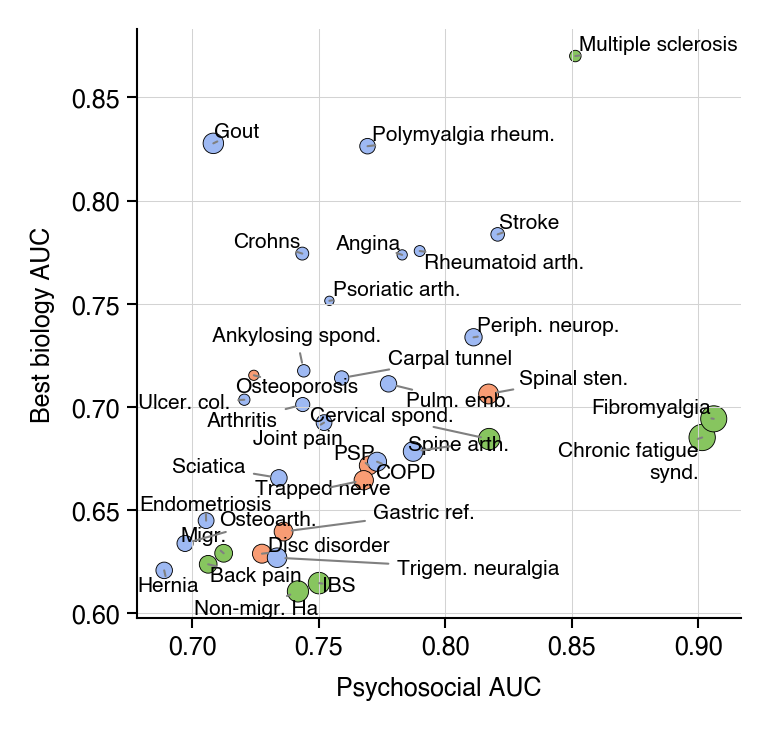

In [24]:
from adjustText import adjust_text
tmp_auc = merged_auc.drop(columns=['Inflammatory', 'Metabolic', 'CBC', 'T1', 'fMRI', 'DWI'])
tmp_auc = tmp_auc[tmp_auc.index.isin(ncis)]
tmp_auc.index = [dico_names_nfl[i] for i in tmp_auc.index]

l2 = [tmp_auc[['Blood','PRS','Bone','Stacked']].iloc[i,:].max() for i in range(tmp_auc.shape[0])]
# l2_labels = [tmp.iloc[i,:].sort_values().index[-1] for i in range(tmp.shape[0])]
tmp2 = tmp_auc.drop(columns=['Psycho'])
l2_labels = [tmp2.iloc[i,:].sort_values().index[-1] for i in range(tmp2.shape[0])]
bio_psyc = pd.DataFrame(np.stack([l2,tmp_auc['Psycho'].values,tmp_auc.index]).T,
                        columns=['Biology ROC-AUC','Psychosocial ROC-AUC','NCI'],index=l2_labels)

bio_psyc['diff'] = abs(bio_psyc['Biology ROC-AUC'] - bio_psyc['Psychosocial ROC-AUC'])

# 2. Normalize or scale the differences to define point sizes. Here, we're scaling it by a factor of 2000 for visual clarity.
bio_psyc['scaled_diff'] = bio_psyc['diff'] * 2000

# create a color palette that only includes the necessary colors
color_palette = {k: color_mapping[k] for k in bio_psyc.index.unique()}

fig,ax = plt.subplots(figsize=(2.6,2.6))
# 3. Use the scaled differences as the sizes for your scatterplot.
sns.scatterplot(data=bio_psyc, y='Biology ROC-AUC', x='Psychosocial ROC-AUC', hue=bio_psyc.index, 
                palette=color_palette, legend=False, 
                size='scaled_diff',  # Use 'scaled_diff' column as size
                sizes=(5, 40),  # Define a range for the size
                edgecolor='k', ax=ax)

ax.set_ylabel('Best biology AUC',fontsize=6)
ax.set_xlabel('Psychosocial AUC',fontsize=6)
# ax.set_ylim(.6,.925)
# ax.set_xlim(.6,.925)
# ax.axvline(.70,linewidth=2,linestyle='-',c='grey')
# ax.axhline(.70,linewidth=2,linestyle='-',c='grey')
# ax.set_title('Biological vs. Psychosocial')
sns.despine()
ax.tick_params(which='both', labelsize=6)
# Add gridlines
ax.grid(True,linestyle='-', linewidth=.25,c='lightgrey')

# Add labels to points where the 'Bio' value is > 0.70 or 'Bio' > 'Sparse'
texts = []
for index, row in bio_psyc.iterrows():
    if row['Biology ROC-AUC'] > 0.6 or row['Biology ROC-AUC'] > row['Psychosocial ROC-AUC'] or row['Psychosocial ROC-AUC'] > 0.6:
        texts.append(ax.text(row['Psychosocial ROC-AUC'], row['Biology ROC-AUC'], row['NCI'], fontsize=5))
        
    # Adjust the labels to prevent overlapping
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=.5))

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/NFL_plot.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

fig.savefig("/Users/Patty/Desktop/NFL_plot.pdf", 
        dpi=300, transparent=True, bbox_inches='tight')

# Number chronic pain sites and prevalence across pain conditions

In [32]:
dico_names = {'joint pain': 'Joint pain',
 'spinal stenosis': 'Spinal stenosis',
 'trapped nerve/compressed nerve': 'Trapped nerve',
 'stroke': 'stroke',
 'multiple sclerosis': 'Multiple sclerosis',
 'chronic obstructive airways disease/copd': 'COPD',
 'sciatica': 'Sciatica',
 'back pain': 'Back pain',
 'osteoporosis': 'Osteoporosis',
 'spine arthritis/spondylitis': 'Spine arthritis',
 'peripheral neuropathy': 'Peripheral neuropathy',
 'angina': 'Angina',
 'migraine': 'Migraine',
 'hernia': 'Hernia',
 'gout': 'Gout',
 'gastro-oesophageal reflux (gord) / gastric reflux': 'Gastric reflux',
 'arthritis (nos)': 'Arthritis',
 'endometriosis': 'Endometriosis',
 'cervical spondylosis': 'Cervical spondylosis',
 'irritable bowel syndrome': 'IBS',
 'headaches (not migraine)': 'Non-migraine headache',
 'chronic fatigue syndrome': 'Chronic fatigue synd.',
 'polymyalgia rheumatica': 'Polymyalgia rheumatica',
 'ulcerative colitis': 'Ulcerative colitis',
 'psoriasis': 'Psoriasis',
 'osteoarthritis': 'Osteoarthritis',
 'diverticular disease/diverticulitis': 'Diverticulitis',
 'rheumatoid arthritis': 'Rheumatoid arthritis',
 'carpal tunnel syndrome': 'Carpal tunnel synd.',
 'disc disorder': 'Disc disorder',
 'pulmonary embolism +/- dvt': 'Pulmonary embolism',
 'ankylosing spondylitis': 'Ankylosing spondylitis',
 'fibromyalgia': 'Fibromyalgia',
 'trigemminal neuralgia': 'Trigemminal neuralgia',
 'crohns disease': 'Crohns disease',
 'parkinsons disease': 'Parkinsons disease',
 'multiple sclerosis': 'Multiple sclerosis',
 'psoriatic arthropathy': 'Psoriatic arthropathy',
 'Post Surgical Pain': 'Post surgical pain',
 'peripheral vascular disease': 'Peripheral vasc. disease',
 'Free': 'Diagnosis-free'
         }

pain_nci = nci_cols_t0 + ['NCI_Free_T0']
pain_nci_t2 = [i.replace('T0','T2') for i in pain_nci]

In [33]:
home_dir = '/Users/Patty/Desktop/EVP_lab/'

NCI = pd.read_csv(home_dir + 'NCI_combined.csv')
NCI['NCI_Free_T0'] = np.where(NCI.NCI_T0 == 0,1,0)
NCI['NCI_Free_T2'] = np.where(NCI.NCI_T2 == 0,1,0)

In [34]:
pain_UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=['eid',
                                                                                    'ChronicWidespreadPain_T0',
                                                                                    'ChronicHeadaches_T0',
                                                                                    'ChronicNeckShoulderPain_T0', 
                                                                                    'ChronicHipPain_T0', 
                                                                                    'ChronicBackPain_T0', 
                                                                                    'ChronicStomachAbdominalPain_T0', 
                                                                                    'ChronicKneePain_T0',
                                                                                    'ChronicFacialPain_T0', 
                                                                                    'NumberChronicPainTypes_T0',
                                                                                    'NumberChronicPainTypes_T0',
                                                                                    'PainLastMonth_T0'
                                                                                    ]) #UKB demographic data
pain_UKB.loc[pain_UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
pain_UKB.loc[pain_UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4

pain_UKB = pain_UKB.merge(NCI,on='eid')

In [174]:
l=[]
for i in pain_nci:
    tmp = pain_UKB[pain_UKB[i] == 1]
    l.append(tmp['NumberChronicPainTypes_T0'].value_counts(normalize=True,sort=False))
    
prev = pd.concat(l,axis=1)
prev.columns = pain_nci

prev = prev.T
prev.columns = ['four','two','three','CP-free','one']
prev = prev.sort_values('CP-free')

/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_29945/217320607.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_.set_ylim((0, 100000))
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_29945/217320607.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


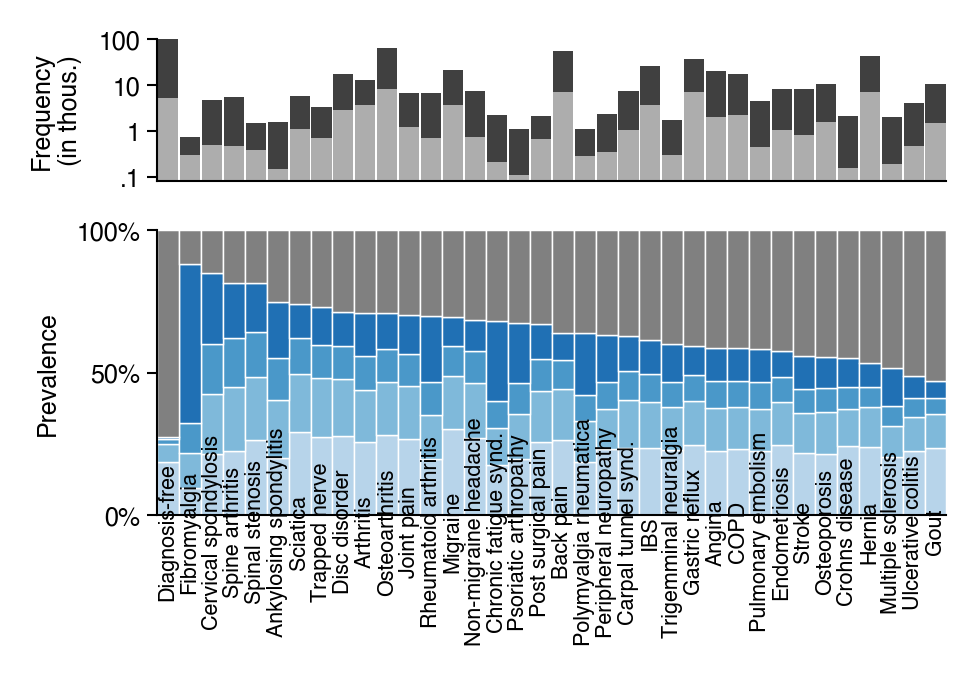

In [300]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,2.5), sharex=True, gridspec_kw={'height_ratios': [0.5,1]})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3.25,2.25), sharex=True, gridspec_kw={'height_ratios': [0.5,1]})

ax_,ax = axes.flatten()

# Set up
# prev = prev.sort_values(2,ascending=False)
# Put Dx-Free on the top row
new_order = ['NCI_Free_T0'] + [index for index in prev.index if index != 'NCI_Free_T0']
prev = prev.reindex(new_order)
painfree = prev['CP-free'].values
one_site = prev['one'].values
two_site = prev['two'].values
three_site = prev['three'].values
four_site = prev['four'].values

r = range(prev.shape[0])
barWidth = 0.95
names = [dico_names[j] for j in [i.split('_')[1] for i in prev.index]]

# Frequency
freq_T0 = NCI[pain_nci].sum().reindex(prev.index)
freq_T2 = NCI[NCI.eid.isin(NCI.dropna(subset='NCI_T2').eid)][pain_nci_t2].sum().reindex([i.replace('T0','T2') for i in prev.index])

ax_.bar(x = r, height = freq_T0, color = 'k', alpha=.75, width=barWidth-0.035)
ax_.bar(x = r, height = freq_T2, color = 'lightgrey', alpha=.75, width=barWidth-0.035)

ax_.set_yscale('log')
ax_.set_ylabel('Frequency\n(in thous.)',fontsize=6)
ax_.set_xticklabels([])
ax_.set_yticks([100, 1000, 10000, 100000])
ax_.set_yticklabels(['.1', '1', '10', '100'],rotation=0,fontsize=6)
ax_.set_ylim((0, 100000))
ax_.set_xlim((-0.5, 25))
ax_.spines[['top', 'right']].set_visible(False)
ax_.spines[['bottom', 'left']]
ax_.tick_params(left=True, bottom=False)
ax_.minorticks_off()

# Prevalence

# Get the rocket_r colormap
# cmap = plt.cm.get_cmap('Oranges')
cmap = plt.cm.get_cmap('Blues')

colors = [cmap(i) for i in [0.3, 0.45, 0.6, .75]]
# colors = [cmap(i) for i in [0.25, 0.5, 0.75, 1.0]]
# Create single site Bars
ax.bar(r, one_site, color=colors[0], edgecolor='white', linewidth=0.35, width=barWidth+0.05, label='Chronic')
# Create two sites Bars
ax.bar(r, two_site, bottom=one_site, color=colors[1], edgecolor='white', linewidth=0.35, width=barWidth+0.05, label='Acute')
# Create three sites Bars
ax.bar(r, three_site, bottom=one_site+two_site, color=colors[2], edgecolor='white', linewidth=0.35, width=barWidth+0.05, label='Acute')
# Create four+ sites Bars
ax.bar(r, four_site, bottom=one_site+two_site+three_site, color=colors[3], edgecolor='white', linewidth=0.35, width=barWidth+0.05, label='Acute')
# Create pain-free Bars
ax.bar(r, painfree, bottom=one_site+two_site+three_site+four_site, color='grey', edgecolor='white', linewidth=0.35, width=barWidth+0.05, label='Pain-free')
 
ax.set_ylabel('Prevalence',fontsize=6)
ax.set_yticks(np.arange(0,1.5,.50))
ax.set_yticklabels(['0%', '50%', '100%'],rotation=0,fontsize=6)
ax.set_xticks(r, names)
# ax.set_xticklabels(names, rotation=90, fontsize=5.25, ha="center",va='bottom',color='k')
ax.set_xticklabels(names, rotation=90, fontsize=5.15, ha="center", va='center', color='k')

ax.set_ylim((0,1))
ax.set_xlim((-0.5, 35.5))
# ax.spines["bottom"].set_bounds((-0.5, 24.5))
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']]
ax.tick_params(left=True,bottom=False)

# Show graphic
plt.tight_layout()
plt.show()

fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/NCI_prevalence_T0.pdf", dpi=300, transparent=True, bbox_inches='tight')

nociplastic/central/WS - fibro, CFS, polymyalgia
Neuropathic/neurovascular - MS, spinal stenosis, sciatic, trapped nerve, neuropathy, neuralgia
nociceptiv/inflammatory - gout, cervical spondylosis, RA, crohns, Ulcerative colitic, IBS

# Pain site prevalence

In [35]:
pain_sites = [
            'ChronicHeadaches_T0',
            'ChronicFacialPain_T0',
            'ChronicNeckShoulderPain_T0', 
            'ChronicStomachAbdominalPain_T0',
            'ChronicBackPain_T0', 
            'ChronicHipPain_T0', 
            'ChronicKneePain_T0',
            'ChronicWidespreadPain_T0']

In [36]:
import pandas as pd

def calculate_prevalence(pain_UKB, pain_nci, pain_sites):
    prevalence_df = pd.DataFrame(index=pain_nci, columns=pain_sites)

    for diagnosis in pain_nci:
        # Filter subjects reporting the current diagnosis
        subjects_with_diagnosis = pain_UKB[pain_UKB[diagnosis] == 1]

        for site in pain_sites:
            # Calculate prevalence for the pain site among subjects with the diagnosis
            prevalence = subjects_with_diagnosis[site].sum() / len(subjects_with_diagnosis) * 100 # Multiply by 100 for percentage
            prevalence_df.loc[diagnosis, site] = prevalence

    return prevalence_df

# Call the function
prevalence_results = calculate_prevalence(pain_UKB, pain_nci, pain_sites)
prevalence_results = prevalence_results[prevalence_results.columns].astype(float)
prevalence_results_z = zscore(prevalence_results)

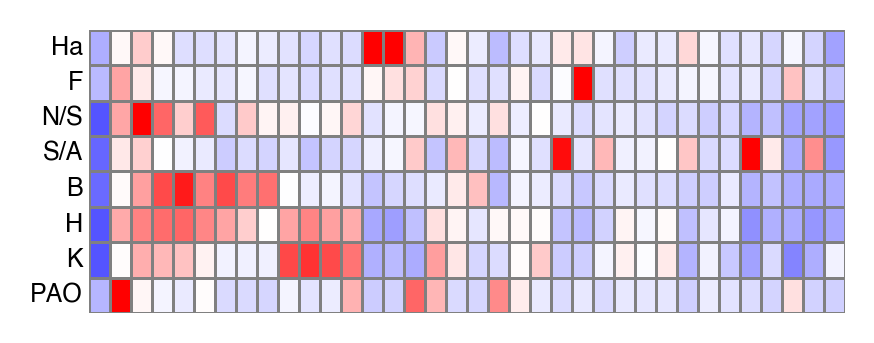

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming prevalence_results is already defined from the previous step

# Set up figure size
# fig = plt.figure(figsize=(4.5, 1.5))

fig = plt.figure(figsize=(3.25,1.25))

# Plot the heatmap
ax = sns.heatmap(data=prevalence_results_z.loc[prev.index].T, 
                 center=0, vmin=-2, vmax=3, cmap="bwr",
                 linewidth=.25,xticklabels=False,yticklabels=True,cbar=False,
                 linecolor='grey',
                 annot=False, fmt=".2f", square=False)

ax.tick_params(which='both',length=0)
# ax.set_xticklabels(names,fontsize=5.15)
ax.set_yticklabels([
    'Ha',
    'F',
    'N/S', 
    'S/A',
    'B', 
    'H', 
    'K',
    'PAO'
    ],fontsize=6)

# Change the fontsize of title
plt.title("")

# Show the plot
plt.show()

# Save the figure
fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/paintype_HM.pdf", dpi=300, transparent=True, bbox_inches='tight')
